In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [2]:
granger_df_all_T = pd.read_csv('../results_final_Jan15/granger_draft_T_signed_score.csv', index_col=0)
granger_df_all_A = pd.read_csv('../results_final_Jan15/granger_draft_A_signed_score.csv', index_col=0)
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [3]:
granger_df_all_T_pvals = pd.read_csv('../results_final_Jan15/granger_draft_T_p.csv', index_col=0)
granger_df_all_A_pvals = pd.read_csv('../results_final_Jan15/granger_draft_A_p.csv', index_col=0)

granger_df_all_T_pvals.index = granger_df_all_T_pvals.index.str.replace('_x', '')
granger_df_all_T_pvals.columns = granger_df_all_T_pvals.columns.str.replace('_y', '')
granger_df_all_A_pvals.index = granger_df_all_A_pvals.index.str.replace('_x', '')
granger_df_all_A_pvals.columns = granger_df_all_A_pvals.columns.str.replace('_y', '')

In [4]:
cluster_df = pd.read_csv('../results_Jun2_suppl/cluster_df_extreme_A_draft.csv', index_col=0)

In [5]:
goi = ['ESRRA', 'ZEB1', 'CDH1', 'GAPDH', 'SNAI1', 'AHR', 'ARNT']

In [6]:
assert all(g in adata.var_names for g in goi), "Some genes not found in adata.var_names"

In [7]:
goi

['ESRRA', 'ZEB1', 'CDH1', 'GAPDH', 'SNAI1', 'AHR', 'ARNT']

In [8]:
ranked_df_T =  (granger_df_all_T.abs()
 .reset_index()  # Preserve the index as a column before melting
 .melt(id_vars='index', ignore_index=True)  # Keep index column during melt
 .rename(columns={'variable': 'target', 'index': 'source', 'value': 'granger_score'})
 .sort_values('granger_score', ascending=False)
 .reset_index(drop=True)
)

In [9]:
(ranked_df_T['granger_score'] >= 6.93147).sum()

10851

In [10]:
ranked_df_T_pvals = (
    granger_df_all_T_pvals.reset_index()
    .melt(id_vars='index', ignore_index=True)
    .rename(columns={'variable': 'target', 'index': 'source', 'value': 'pval'})
    .sort_values('pval', ascending=True)
    .reset_index(drop=True)
)
ranked_df_A_pvals = (
    granger_df_all_A_pvals.reset_index()
    .melt(id_vars='index', ignore_index=True)
    .rename(columns={'variable': 'target', 'index': 'source', 'value': 'pval'})
    .sort_values('pval', ascending=True)
    .reset_index(drop=True)
)

In [11]:
ranked_df_A_pvals

,source,target,pval
0,DLX2,LTBP3,0.000000e+00
1,HLX,NFATC3,0.000000e+00
2,TCF7L1,MTRNR2L12,0.000000e+00
3,AKAP8,MPST,1.086931e-289
4,BHLHE40,SIX1,1.233021e-257
...,...,...,...
2430848,MNT,MNT,1.000000e+00
2430849,THRA,THRA,1.000000e+00
2430850,GABPA,GABPA,1.000000e+00
2430851,PLSCR1,PLSCR1,1.000000e+00


In [12]:
ranked_df_T_pvals

,source,target,pval
0,PA2G4,PPIL4,0.000000e+00
1,OSR2,DDX19A,0.000000e+00
2,ZNF667,TERF2IP,0.000000e+00
3,SP1,RGS4,3.547645e-292
4,TBX2,ELMOD2,1.740465e-194
...,...,...,...
2430848,RXRA,RXRA,1.000000e+00
2430849,ZNF385A,ZNF385A,1.000000e+00
2430850,GATA3,GATA3,1.000000e+00
2430851,RARA,RARA,1.000000e+00


In [13]:
ranked_df_A_pvals['log10_pval'] = -np.log10(ranked_df_A_pvals['pval'] + 1e-300)

In [14]:
ranked_df_A_pvals

,source,target,pval,log10_pval
0,DLX2,LTBP3,0.000000e+00,300.000000
1,HLX,NFATC3,0.000000e+00,300.000000
2,TCF7L1,MTRNR2L12,0.000000e+00,300.000000
3,AKAP8,MPST,1.086931e-289,288.963798
4,BHLHE40,SIX1,1.233021e-257,256.909030
...,...,...,...,...
2430848,MNT,MNT,1.000000e+00,-0.000000
2430849,THRA,THRA,1.000000e+00,-0.000000
2430850,GABPA,GABPA,1.000000e+00,-0.000000
2430851,PLSCR1,PLSCR1,1.000000e+00,-0.000000


In [15]:
ranked_df_T_pvals['log10_pval'] = -np.log10(ranked_df_T_pvals['pval'] + 1e-300)


In [16]:
total_scores = pd.DataFrame(ranked_df_A_pvals.groupby('source')['log10_pval'].sum())
total_scores['source'] = total_scores.index
total_scores = total_scores.reset_index(drop=True)

In [17]:
total_scores[total_scores['source'].isin(goi)]

,log10_pval,source
4,3458.040769,AHR
16,5433.862934,ARNT
72,5961.053584,ESRRA
273,6945.201692,SNAI1
341,4965.197635,ZEB1


In [18]:
total_scores_T_topk = pd.DataFrame({
    'top1': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
    'top5': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
    'top10': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
    'top100': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
    'top1000': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
    'all': ranked_df_T_pvals.groupby('source')['log10_pval'].sum()
})
total_scores_T_topk['source'] = total_scores_T_topk.index
total_scores_T_topk = total_scores_T_topk.reset_index(drop=True)

# Add rankings for each column
total_scores_T_topk['top1_rank'] = total_scores_T_topk['top1'].rank(ascending=False)
total_scores_T_topk['top5_rank'] = total_scores_T_topk['top5'].rank(ascending=False)
total_scores_T_topk['top10_rank'] = total_scores_T_topk['top10'].rank(ascending=False)
total_scores_T_topk['top100_rank'] = total_scores_T_topk['top100'].rank(ascending=False) 
total_scores_T_topk['top1000_rank'] = total_scores_T_topk['top1000'].rank(ascending=False)
total_scores_T_topk['all_rank'] = total_scores_T_topk['all'].rank(ascending=False)

total_scores_T_topk['cluster'] = total_scores_T_topk['source'].map(cluster_df['cluster'])

In [19]:
total_scores_T_topk[total_scores_T_topk['source'].isin(goi)]

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank,cluster
4,29.022485,72.468878,113.752865,506.791685,1970.431289,3475.895146,AHR,261.0,377.0,390.0,404.0,400.0,394.0,3.0
16,53.516025,181.630467,263.272272,854.933998,3101.240195,5213.642171,ARNT,97.0,72.0,79.0,138.0,112.0,112.0,4.0
72,46.658294,177.633929,287.183831,1047.848362,3128.816127,4842.532657,ESRRA,121.0,76.0,59.0,56.0,108.0,148.0,1.0
273,24.042487,109.423746,190.619869,819.778968,2632.568615,4159.242098,SNAI1,330.0,228.0,183.0,157.0,207.0,257.0,0.0
341,43.647923,160.225269,269.951278,1057.026813,3586.425782,5772.983477,ZEB1,143.0,103.0,74.0,54.0,50.0,70.0,0.0


In [20]:
ranked_df_A_pvals['log10_pval'] = -np.log10(ranked_df_A_pvals['pval'] + 1e-300)

In [21]:
total_scores_A_topk = pd.DataFrame({
    'top1': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
    'top5': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
    'top10': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
    'top100': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
    'top1000': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
    'all': ranked_df_A_pvals.groupby('source')['log10_pval'].sum()
})
total_scores_A_topk['source'] = total_scores_A_topk.index
total_scores_A_topk = total_scores_A_topk.reset_index(drop=True)

# Add rankings for each column
total_scores_A_topk['top1_rank'] = total_scores_A_topk['top1'].rank(ascending=False)
total_scores_A_topk['top5_rank'] = total_scores_A_topk['top5'].rank(ascending=False)
total_scores_A_topk['top10_rank'] = total_scores_A_topk['top10'].rank(ascending=False)
total_scores_A_topk['top100_rank'] = total_scores_A_topk['top100'].rank(ascending=False) 
total_scores_A_topk['top1000_rank'] = total_scores_A_topk['top1000'].rank(ascending=False)
total_scores_A_topk['all_rank'] = total_scores_A_topk['all'].rank(ascending=False)

total_scores_A_topk['cluster'] = total_scores_A_topk['source'].map(cluster_df['cluster'])


In [22]:
total_scores_A_topk[total_scores_A_topk['source'].isin(goi)]

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank,cluster
4,22.543742,92.820112,139.265143,637.186508,2173.171487,3458.040769,AHR,276.0,251.0,275.0,330.0,395.0,412.0,3.0
16,14.533780,62.201672,100.782025,551.542692,2618.026170,5433.862934,ARNT,395.0,365.0,385.0,373.0,340.0,256.0,4.0
72,25.858799,93.733894,161.165204,809.274580,3190.066102,5961.053584,ESRRA,235.0,249.0,239.0,232.0,242.0,190.0,1.0
273,30.136564,106.082621,186.565600,890.729701,3606.297153,6945.201692,SNAI1,195.0,212.0,191.0,182.0,148.0,109.0,0.0
341,15.344681,71.629350,126.855193,757.604297,3231.693804,4965.197635,ZEB1,381.0,312.0,308.0,262.0,229.0,314.0,0.0


In [23]:
draft_matrix = pd.read_excel('../data/top_regulated_genes_48_epi_tfs.xlsx', index_col=0)
draft_matrix.columns = draft_matrix.columns.str.replace('_x', '')
draft_matrix.index = draft_matrix.index.str.replace('_y', '')

In [24]:
for g in goi:
    if g in draft_matrix.columns:
        print(g)
    else:
        print(f"{g} not found in draft_matrix.columns")

ESRRA
ZEB1
CDH1 not found in draft_matrix.columns
GAPDH not found in draft_matrix.columns
SNAI1 not found in draft_matrix.columns
AHR
ARNT


In [25]:
# # goi in granger_df_all_T_pvals.index
# for g in goi:
#     if g in granger_df_all_T_pvals.index:
#         print(g)
#     else:
#         print(f"{g} not found in granger_df_all_T_pvals.index")

# print('genes')
# for g in goi:
#     if g in granger_df_all_T_pvals.columns:
#         print(g)
#     else:
#         print(f"{g} not found in granger_df_all_T_pvals.columns")


In [26]:
# granger_df_all_T

In [27]:
ranked_df_T_pvals['source_cluster'] = ranked_df_T_pvals['source'].map(cluster_df['cluster'])
ranked_df_T_pvals['target_cluster'] = ranked_df_T_pvals['target'].map(cluster_df['cluster'])

ranked_df_A_pvals['source_cluster'] = ranked_df_A_pvals['source'].map(cluster_df['cluster'])
ranked_df_A_pvals['target_cluster'] = ranked_df_A_pvals['target'].map(cluster_df['cluster'])

In [28]:
ranked_df_A_pvals_1 = ranked_df_A_pvals[ranked_df_A_pvals['source_cluster'] == 1]

In [29]:
ranked_df_T_pvals_1 = ranked_df_T_pvals[ranked_df_T_pvals['source_cluster'] == 1]


In [30]:
def calculate_topk_scores(ranked_df):
    """Calculate top-k scores and rankings for each source in ranked dataframe.
    
    Args:
        ranked_df: DataFrame with columns ['source', 'log10_pval']
        
    Returns:
        DataFrame with top-k scores and rankings for each source
    """
    # Calculate top-k scores
    total_scores = pd.DataFrame({
        'top1': ranked_df.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
        'top5': ranked_df.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
        'top10': ranked_df.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
        'top100': ranked_df.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
        'top1000': ranked_df.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
        'all': ranked_df.groupby('source')['log10_pval'].sum()
    })
    
    total_scores['source'] = total_scores.index
    total_scores = total_scores.reset_index(drop=True)

    # Add rankings for each column
    for col in ['top1', 'top5', 'top10', 'top100', 'top1000', 'all']:
        total_scores[f'{col}_rank'] = total_scores[col].rank(ascending=False)
        
    return total_scores

In [31]:
calculate_topk_scores(ranked_df_A_pvals_1)

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank
0,14.271164,44.992351,74.961066,311.934963,1357.116529,2987.154226,ALX1,34.0,42.0,43.0,43.0,43.0,41.0
1,170.488063,504.393148,731.398446,3068.233897,12421.202274,22440.798518,ARID5A,2.0,2.0,2.0,2.0,2.0,1.0
2,14.536044,56.508730,98.108773,574.855024,2834.007950,5543.984679,ATF3,33.0,35.0,36.0,31.0,27.0,24.0
3,16.326980,68.378549,114.710884,531.282988,2304.927975,4658.756432,ATF4,31.0,29.0,29.0,35.0,34.0,34.0
4,55.147933,156.267661,229.607008,840.736238,2987.343003,5158.520953,ATF5,9.0,12.0,12.0,16.0,23.0,28.0
5,17.997953,63.048998,110.292836,692.664901,3644.430766,6925.837769,CEBPG,29.0,32.0,32.0,23.0,16.0,16.0
6,18.445244,73.717717,125.963045,726.976850,2888.932967,5167.920285,CENPA,28.0,25.0,25.0,21.0,25.0,27.0
7,92.513482,357.407366,578.834804,2262.942480,8504.280882,14994.754205,CSRNP1,5.0,3.0,3.0,4.0,4.0,4.0
8,14.164025,60.527870,100.840555,537.786533,2583.251765,5248.798500,DDIT3,35.0,34.0,35.0,34.0,29.0,26.0
9,100.377625,318.897942,539.503201,2869.479763,11721.764036,21389.314373,EGR2,3.0,5.0,4.0,3.0,3.0,2.0


In [49]:
top100_T = total_scores_T_topk[total_scores_T_topk['top10_rank'] <= 100]
top100_A = total_scores_A_topk[total_scores_A_topk['top10_rank'] <= 100]

In [50]:
# Get sets of sources
sources_T = set(top100_T['source'])
sources_A = set(top100_A['source'])

# Find intersection and unique sets
common_sources = sources_T & sources_A
unique_T = sources_T - sources_A  
unique_A = sources_A - sources_T

# Create dataframes
common_df = pd.DataFrame({'source': list(common_sources)})
unique_T_df = pd.DataFrame({'source': list(unique_T)})
unique_A_df = pd.DataFrame({'source': list(unique_A)})

In [51]:
assert 'ESRRA' in unique_T_df['source'].values and 'ARNT' in unique_T_df['source'].values

In [52]:
unique_A_df['cluster'] = unique_A_df['source'].map(cluster_df['cluster'])

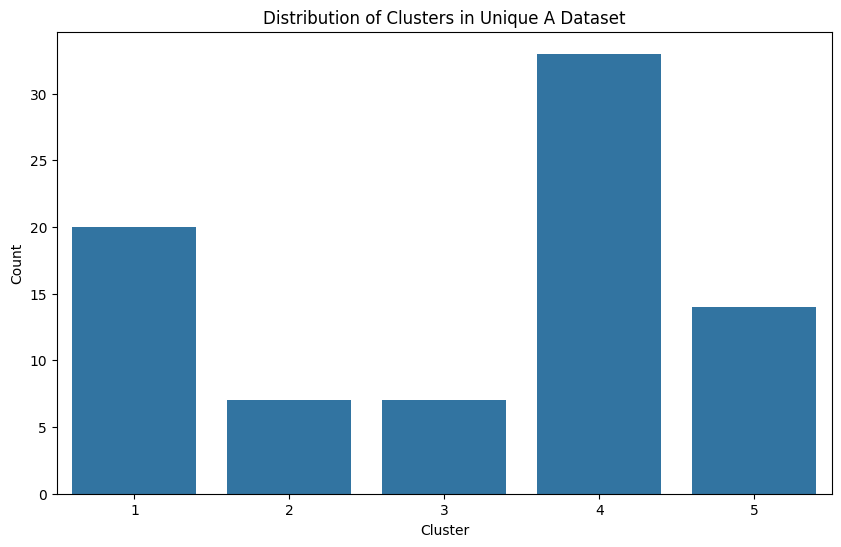

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.barplot(x=(unique_A_df['cluster'].value_counts().index + 1).astype(int), 
            y=unique_A_df['cluster'].value_counts().values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters in Unique A Dataset')
plt.show()

In [37]:
unique_A_df

,source,cluster
0,ZNF3,4.0
1,CDC5L,3.0
2,ZNF92,3.0
3,ZNF566,3.0
4,DLX4,2.0
...,...,...
76,KDM5B,4.0
77,ZNF419,3.0
78,PAX9,3.0
79,TCF3,0.0


In [38]:
unique_A_df.to_csv('../results_Jun2_suppl/unique_A_df_top10_top100.csv', index=False)

In [39]:
unique_A_df['source']

0       ZNF3
1      CDC5L
2      ZNF92
3     ZNF566
4       DLX4
       ...  
76     KDM5B
77    ZNF419
78      PAX9
79      TCF3
80      TMF1
Name: source, Length: 81, dtype: object

In [40]:
unique_A_regulated_df = (ranked_df_A_pvals[ranked_df_A_pvals['source'].isin(unique_A_df['source'])]
 .groupby('source')
 .apply(lambda x: x.nlargest(10, 'log10_pval'))
 .reset_index(drop=True))
unique_A_regulated_df.to_csv('../results_Jun2_suppl/unique_A_regulated_df_top10_top100.csv', index=False)

In [41]:
import json
pathway_path = '../data/HALLMARK_APOPTOSIS.v2025.1.Hs.json'
with open(pathway_path, 'r') as f:
    pathway_data = json.load(f)

In [42]:
pathway_data['HALLMARK_APOPTOSIS']['geneSymbols']

['ADD1',
 'AIFM3',
 'ANKH',
 'ANXA1',
 'APP',
 'ATF3',
 'AVPR1A',
 'BAX',
 'BCAP31',
 'BCL10',
 'BCL2L1',
 'BCL2L10',
 'BCL2L11',
 'BCL2L2',
 'BGN',
 'BID',
 'BIK',
 'BIRC3',
 'BMF',
 'BMP2',
 'BNIP3L',
 'BRCA1',
 'BTG2',
 'BTG3',
 'CASP1',
 'CASP2',
 'CASP3',
 'CASP4',
 'CASP6',
 'CASP7',
 'CASP8',
 'CASP9',
 'CAV1',
 'CCNA1',
 'CCND1',
 'CCND2',
 'CD14',
 'CD2',
 'CD38',
 'CD44',
 'CD69',
 'CDC25B',
 'CDK2',
 'CDKN1A',
 'CDKN1B',
 'CFLAR',
 'CLU',
 'CREBBP',
 'CTH',
 'CTNNB1',
 'CYLD',
 'DAP',
 'DAP3',
 'DCN',
 'DDIT3',
 'DFFA',
 'DIABLO',
 'DNAJA1',
 'DNAJC3',
 'DNM1L',
 'DPYD',
 'EBP',
 'EGR3',
 'EMP1',
 'ENO2',
 'ERBB2',
 'ERBB3',
 'EREG',
 'ETF1',
 'F2',
 'F2R',
 'FAS',
 'FASLG',
 'FDXR',
 'FEZ1',
 'GADD45A',
 'GADD45B',
 'GCH1',
 'GNA15',
 'GPX1',
 'GPX3',
 'GPX4',
 'GSN',
 'GSR',
 'GSTM1',
 'GUCY2D',
 'H1-0',
 'HGF',
 'HMGB2',
 'HMOX1',
 'HSPB1',
 'IER3',
 'IFITM3',
 'IFNB1',
 'IFNGR1',
 'IGF2R',
 'IGFBP6',
 'IL18',
 'IL1A',
 'IL1B',
 'IL6',
 'IRF1',
 'ISG20',
 'JUN',
 'KRT18',

In [43]:
top1000_T = total_scores_T_topk[total_scores_T_topk['top10_rank'] <= 1000]
top1000_A = total_scores_A_topk[total_scores_A_topk['top10_rank'] <= 1000]

In [59]:
unique_A_regulated_top500_df = (ranked_df_A_pvals[ranked_df_A_pvals['source'].isin(unique_A_df['source'])]
 .groupby('source')
 .apply(lambda x: x.nlargest(500, 'log10_pval'))
 .reset_index(drop=True))
unique_A_regulated_top500_df.to_csv('../results_Jun2_suppl/unique_A_regulated_top500_df_top10_top500.csv', index=False)

In [63]:
filtered_ranks = unique_A_regulated_top500_df[unique_A_regulated_top500_df['target'].isin(pathway_data['HALLMARK_APOPTOSIS']['geneSymbols'])]

In [64]:
filtered_ranks

,source,target,pval,log10_pval,source_cluster,target_cluster
26,ADNP2,DAP,2.088377e-12,11.680191,3.0,1.0
247,ADNP2,ISG20,1.272520e-04,3.895335,3.0,1.0
342,ADNP2,IRF1,6.146037e-04,3.211405,3.0,3.0
386,ADNP2,BCL10,1.037564e-03,2.983985,3.0,1.0
401,ADNP2,EMP1,1.192186e-03,2.923656,3.0,3.0
...,...,...,...,...,...,...
39942,ZNF891,CDKN1A,1.923156e-03,2.715985,4.0,3.0
39943,ZNF891,SQSTM1,1.929841e-03,2.714478,4.0,1.0
40009,ZNF92,FDXR,4.008090e-22,21.397063,3.0,3.0
40070,ZNF92,CREBBP,4.779747e-10,9.320595,3.0,4.0


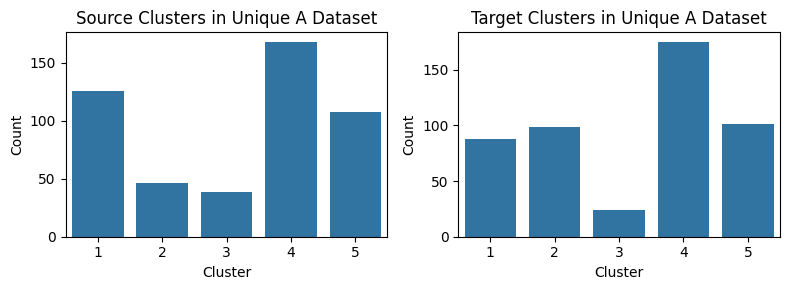

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.barplot(x=(filtered_ranks['source_cluster'].value_counts().index + 1).astype(int), 
            y=filtered_ranks['source_cluster'].value_counts().values, ax=ax1)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Count')
ax1.set_title('Source Clusters in Unique A Dataset')

sns.barplot(x=(filtered_ranks['target_cluster'].value_counts().index + 1).astype(int), 
            y=filtered_ranks['target_cluster'].value_counts().values, ax=ax2)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Count')
ax2.set_title('Target Clusters in Unique A Dataset')

plt.tight_layout()
plt.show()

In [66]:
filtered_ranks.to_csv('../results_Jun2_suppl/more_filtered_unique_A_regulated_df_top10_top500_apoptotic_genes.csv', index=False)